<a href="https://colab.research.google.com/github/minhquyminhquy/Lid-Driven-Cavity-Flow-Simulation/blob/main/NavierStroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Epoch    0 | Loss: 4.831e+00 | LR: 1.0e-03
Loss weights: [2.7  2.7  2.7  2.69 2.7 ]
Epoch  100 | Loss: 1.926e+00 | LR: 1.0e-03
Loss weights: [1.86 2.28 2.3  1.2  2.5 ]
Epoch  200 | Loss: 1.039e+00 | LR: 1.0e-03
Loss weights: [1.48 1.9  2.13 0.65 2.39]
Epoch  300 | Loss: 6.151e-01 | LR: 1.0e-03
Loss weights: [1.18 1.33 1.65 0.39 2.33]
Epoch  400 | Loss: 3.829e-01 | LR: 1.0e-03
Loss weights: [1.02 0.89 1.18 0.24 2.26]
Epoch  500 | Loss: 2.450e-01 | LR: 1.0e-03
Loss weights: [0.88 0.56 0.86 0.15 2.15]
Epoch  600 | Loss: 1.588e-01 | LR: 1.0e-03
Loss weights: [0.74 0.32 0.62 0.1  2.02]
Epoch  700 | Loss: 1.583e-01 | LR: 1.0e-03
Loss weights: [0.6  0.17 0.45 0.1  1.87]
Epoch  800 | Loss: 1.580e-01 | LR: 1.0e-03
Loss weights: [0.46 0.1  0.29 0.1  1.74]
Epoch  900 | Loss: 1.580e-01 | LR: 1.0e-03
Loss weights: [0.31 0.1  0.17 0.1  1.56]
Epoch 1000 | Loss: 1.576e-01 | LR: 1.0e-03
Loss weights: [0.18 0.1  0.1  0.1  1.31]
Epoch 1100 | Loss: 1.578e-01 | LR: 1.0e-03
Loss weights: 

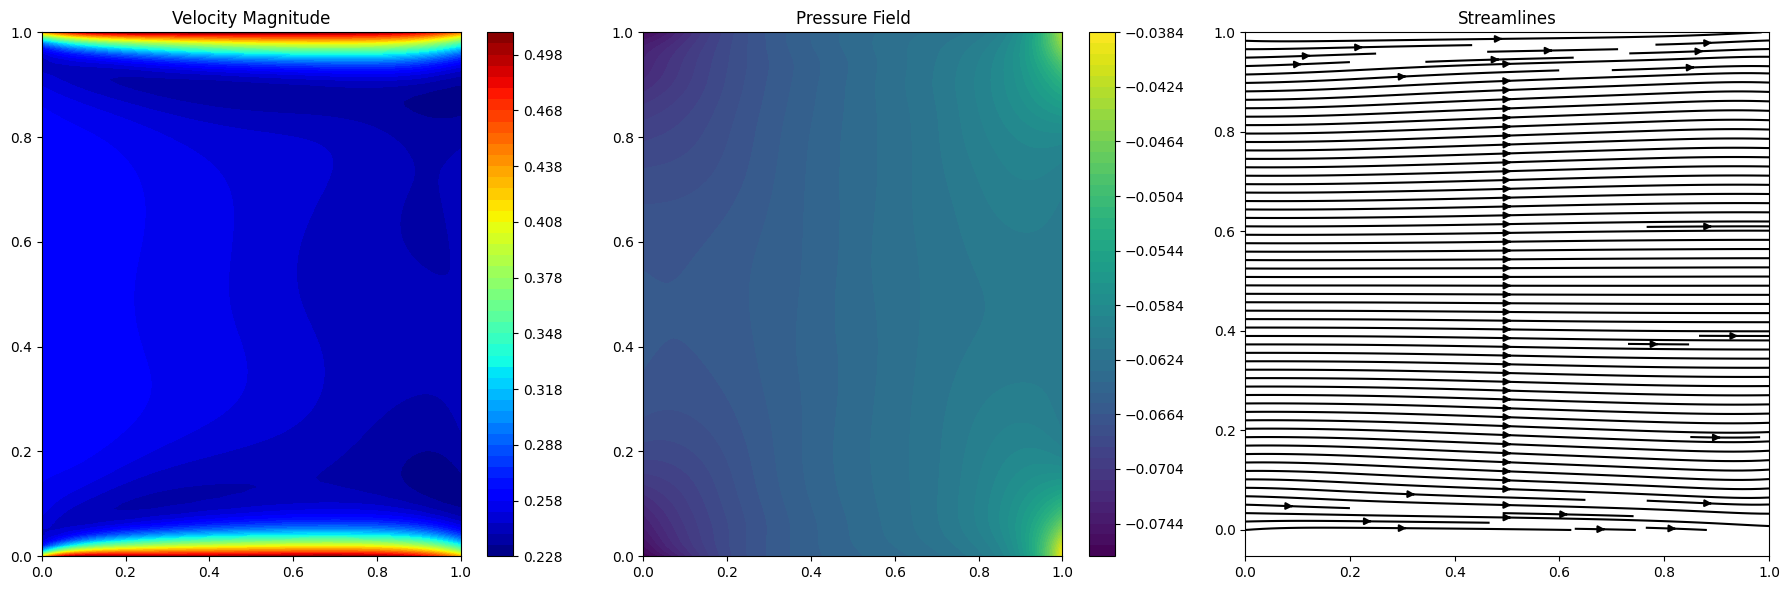

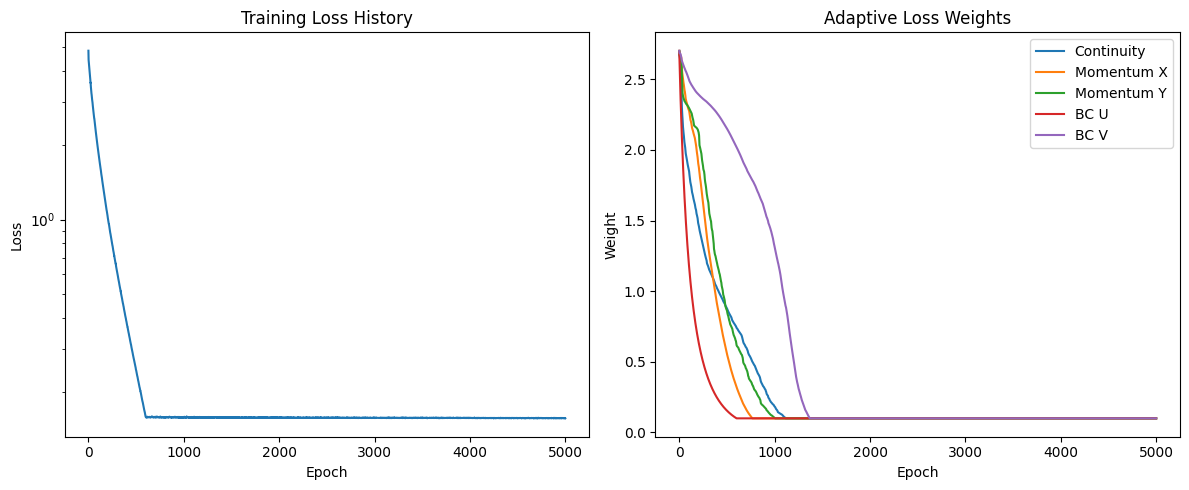

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from torch.utils.data import Dataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Problem parameters
Re = 1000            # Reynolds number
L = 1.0              # Cavity length
U_lid = 1.0          # Lid velocity
nu = U_lid * L / Re  # Kinematic viscosity
rho = 1.0            # Density

# Domain parameters
x_min, x_max = 0.0, L
y_min, y_max = 0.0, L

# Neural network parameters
hidden_layers = 5
hidden_units = 128

# Training parameters
epochs = 5000
batch_size = 2048
lr = 1e-3

# Adaptive loss weights
num_loss_terms = 5  # continuity, x-mom, y-mom, BCs, div-free

# Generate training data
def generate_data(n_samples):
    # Collocation points
    x = torch.rand(n_samples, 1) * L
    y = torch.rand(n_samples, 1) * L

    # Boundary points (top, bottom, left, right)
    n_b = n_samples // 4
    top = torch.cat([
        torch.rand(n_b, 1) * L,
        torch.ones(n_b, 1) * y_max
    ], dim=1)
    bottom = torch.cat([
        torch.rand(n_b, 1) * L,
        torch.ones(n_b, 1) * y_min
    ], dim=1)
    left = torch.cat([
        torch.ones(n_b, 1) * x_min,
        torch.rand(n_b, 1) * L
    ], dim=1)
    right = torch.cat([
        torch.ones(n_b, 1) * x_max,
        torch.rand(n_b, 1) * L
    ], dim=1)

    X_col = torch.cat([x, y], dim=1)
    X_bnd = torch.cat([top, bottom, left, right], dim=0)

    return X_col.to(device), X_bnd.to(device)

# Create dataset
class NSDataset(Dataset):
    def __init__(self, n_samples=10000):
        self.X_col, self.X_bnd = generate_data(n_samples)

    def __len__(self):
        return len(self.X_col) + len(self.X_bnd)

    def __getitem__(self, idx):
        if idx < len(self.X_col):
            return self.X_col[idx], 0  # 0 indicates collocation point
        else:
            return self.X_bnd[idx - len(self.X_col)], 1  # 1 indicates boundary point

# Neural network architecture
class NavierStokesPINN(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, hidden_units))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_units, 3))  # Output: u, v, p

        self.net = nn.Sequential(*layers)
        self.lambda_weights = nn.Parameter(torch.ones(num_loss_terms, device=device))

    def forward(self, x, y):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, device=device)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32, device=device)

        out = self.net(torch.cat([x, y], dim=1))
        u = out[:, 0:1]
        v = out[:, 1:2]
        p = out[:, 2:3]
        return u, v, p

    def compute_losses(self, X_col, X_bnd):
        # Collocation points losses
        losses = self.compute_pde_loss(X_col)

        # Boundary condition losses
        bc_losses = self.compute_bc_loss(X_bnd)

        return {**losses, **bc_losses}

    def compute_pde_loss(self, X):
        x = X[:, 0:1].requires_grad_(True)
        y = X[:, 1:2].requires_grad_(True)

        u, v, p = self.forward(x, y)

        # First derivatives
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                                create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),
                                create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v),
                                create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p),
                                create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p),
                                create_graph=True)[0]

        # Second derivatives
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                 create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
                                 create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x),
                                 create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y),
                                 create_graph=True)[0]

        # Continuity equation
        continuity = u_x + v_y

        # Momentum equations
        momentum_x = u*u_x + v*u_y + (1/rho)*p_x - nu*(u_xx + u_yy)
        momentum_y = u*v_x + v*v_y + (1/rho)*p_y - nu*(v_xx + v_yy)

        return {
            'continuity': torch.mean(continuity**2),
            'momentum_x': torch.mean(momentum_x**2),
            'momentum_y': torch.mean(momentum_y**2)
        }

    def compute_bc_loss(self, X_bnd):
        x = X_bnd[:, 0:1]
        y = X_bnd[:, 1:2]
        u_pred, v_pred, _ = self.forward(x, y)

        # Lid-driven cavity BCs
        top_mask = (y == y_max).squeeze()
        bottom_mask = (y == y_min).squeeze()
        side_mask = (x == x_min) | (x == x_max)

        # Top boundary (moving lid)
        u_top = torch.where(top_mask, u_pred - U_lid, torch.zeros_like(u_pred))
        v_top = torch.where(top_mask, v_pred, torch.zeros_like(v_pred))

        # Other boundaries (no-slip)
        u_noslip = torch.where(~top_mask & side_mask | bottom_mask,
                              u_pred, torch.zeros_like(u_pred))
        v_noslip = torch.where(~top_mask & side_mask | bottom_mask,
                              v_pred, torch.zeros_like(v_pred))

        bc_loss_u = torch.mean(u_top**2) + torch.mean(u_noslip**2)
        bc_loss_v = torch.mean(v_top**2) + torch.mean(v_noslip**2)

        return {
            'bc_u': bc_loss_u,
            'bc_v': bc_loss_v
        }

# Initialize model and optimizer
model = NavierStokesPINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5)

# Create data loaders
dataset = NSDataset(n_samples=10000)
colloc_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
loss_history = []
lambda_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for X, data_type in colloc_loader:
        optimizer.zero_grad()

        X_col = X[data_type == 0]
        X_bnd = X[data_type == 1]

        losses = model.compute_losses(X_col, X_bnd)

        # Get adaptive weights
        weights = torch.clamp(torch.exp(model.lambda_weights), 0.1, 10.0)

        # Weighted loss
        total_loss = weights[0] * losses['continuity'] + \
                    weights[1] * losses['momentum_x'] + \
                    weights[2] * losses['momentum_y'] + \
                    weights[3] * losses['bc_u'] + \
                    weights[4] * losses['bc_v']

        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    scheduler.step(epoch_loss)
    loss_history.append(epoch_loss)
    lambda_history.append(weights.detach().cpu().numpy())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Loss: {epoch_loss:.3e} | LR: {optimizer.param_groups[0]['lr']:.1e}")
        print(f"Loss weights: {weights.detach().cpu().numpy().round(2)}")

# Plotting functions
def plot_results(model, resolution=100):
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x, y)

    with torch.no_grad():
        U, V, P = model(
            torch.tensor(X.flatten(), dtype=torch.float32, device=device).unsqueeze(1),
            torch.tensor(Y.flatten(), dtype=torch.float32, device=device).unsqueeze(1)
        )

    U = U.cpu().numpy().reshape(resolution, resolution)
    V = V.cpu().numpy().reshape(resolution, resolution)
    P = P.cpu().numpy().reshape(resolution, resolution)

    plt.figure(figsize=(18, 6))

    # Velocity magnitude
    plt.subplot(131)
    plt.contourf(X, Y, np.sqrt(U**2 + V**2), levels=50, cmap='jet')
    plt.colorbar()
    plt.title('Velocity Magnitude')

    # Pressure field
    plt.subplot(132)
    plt.contourf(X, Y, P, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title('Pressure Field')

    # Streamlines
    plt.subplot(133)
    plt.streamplot(X, Y, U, V, density=2, color='k')
    plt.title('Streamlines')

    plt.tight_layout()
    plt.show()

# Generate final plots
plot_results(model)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.semilogy(loss_history)
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(lambda_history)
plt.title('Adaptive Loss Weights')
plt.xlabel('Epoch')
plt.ylabel('Weight')
plt.legend(['Continuity', 'Momentum X', 'Momentum Y', 'BC U', 'BC V'])
plt.tight_layout()
plt.show()